# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [7]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model
from matplotlib import pyplot as pl
from skimage import exposure
from skimage.feature import hog
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [15]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

392


In [10]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

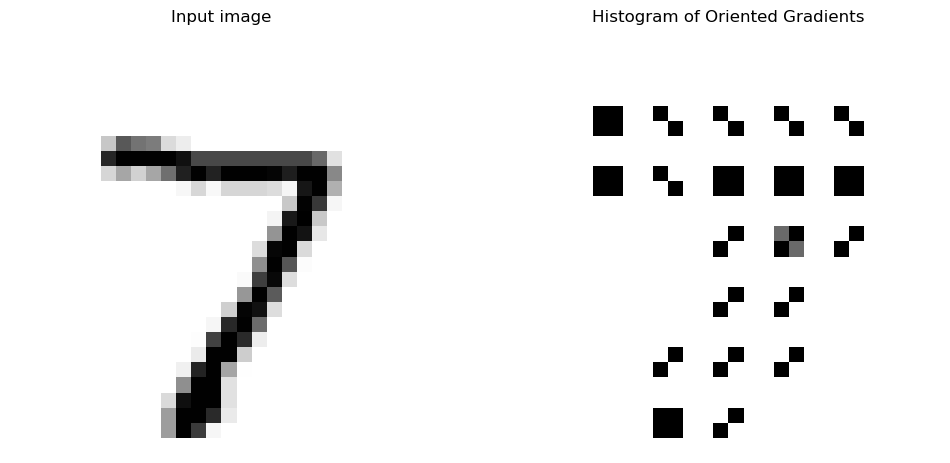

In [11]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [12]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [13]:
model = Sequential([
    Dense(256, input_shape=(hog_size,), activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax'),
])

model.summary()

2023-04-28 15:37:13.993444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               100608    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 103,178
Trainable params: 103,178
Non-trainable params: 0
_________________________________________________________________


2023-04-28 15:37:14.006850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 15:37:14.006902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 15:37:14.010303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 15:37:14.010350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 15:37:14.010383: I tensorflow/compile

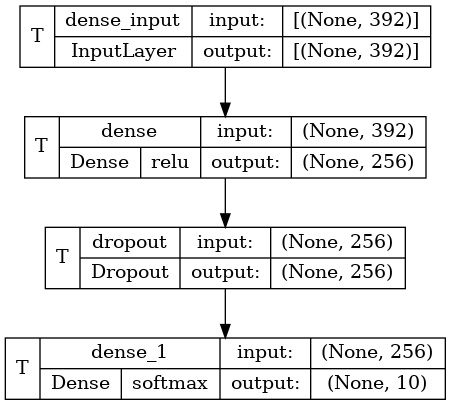

In [14]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
    to_file='mlpf-model.png'
)

Define some constants and train the MLP

In [8]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
 33/422 [=>............................] - ETA: 1s - loss: 1.1475 - accuracy: 0.7540

2023-04-28 09:50:20.506554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


422/422 [==============================] - 3s 6ms/step - loss: 0.2561 - accuracy: 0.9341 - val_loss: 0.0789 - val_accuracy: 0.9767
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.1035 - accuracy: 0.9672 - val_loss: 0.0705 - val_accuracy: 0.9768
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0832 - accuracy: 0.9734 - val_loss: 0.0655 - val_accuracy: 0.9780
Epoch 4/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0705 - accuracy: 0.9772 - val_loss: 0.0631 - val_accuracy: 0.9793
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0599 - accuracy: 0.9813 - val_loss: 0.0638 - val_accuracy: 0.9787
Epoch 6/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0528 - accuracy: 0.9826 - val_loss: 0.0575 - val_accuracy: 0.9833
Epoch 7/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0471 - accuracy: 0.9849 - val_loss: 0.0608 - val_accuracy: 0.9802
Epoch 8/10
422/42

Show the performance of the model

Test score: 0.062235455960035324
Test accuracy: 0.982200026512146


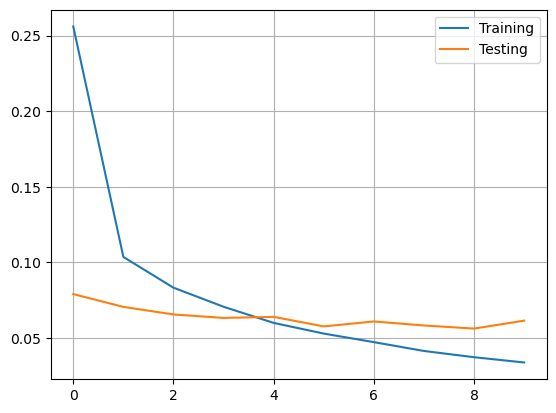

In [9]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 [==============================] - 0s 1ms/step


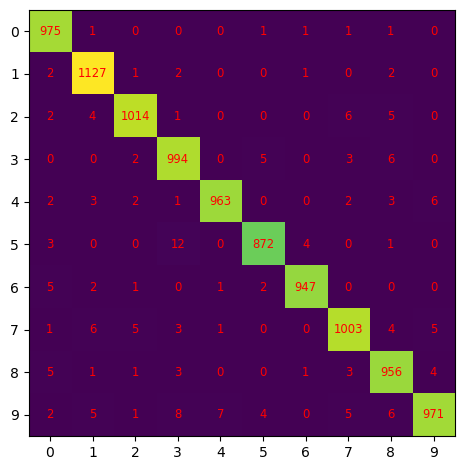

F-score 0: 0.9863429438543246
F-score 1: 0.9868651488616462
F-score 2: 0.9849441476444877
F-score 3: 0.9773844641101278
F-score 4: 0.985670419651996
F-score 5: 0.9819819819819819
F-score 6: 0.9905857740585775
F-score 7: 0.9780594831789371
F-score 8: 0.9765066394279877
F-score 9: 0.9734335839598998


In [10]:
pred = np.argmax(model.predict(X_test_hog), axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])